# Notebook 03: OCR Text Extraction from UML Class Diagrams

This notebook extracts text from detected UML class boxes using OCR, then parses the text into structured class information (name, attributes, methods).

## Pipeline
```
UML Image → YOLO Detection → Crop Class Boxes → OCR → Parse UML Structure
```

## Stages
1. Load trained YOLO model and initialize EasyOCR
2. Detect class boxes in UML diagrams
3. Preprocess and crop detected regions
4. Extract text using EasyOCR
5. Parse UML structure (class name, attributes, methods)
6. Export results as JSON for knowledge graph construction

## 1. Setup & Imports

In [5]:
import os
import sys
import json
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
from ultralytics import YOLO

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.utils.data_loader import download_dataset, load_yolo_split

print(f"Project root: {PROJECT_ROOT}")

Project root: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool


In [6]:
# Configuration
MODEL_PATH = PROJECT_ROOT / "models" / "uml_detector_best.pt"
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "ocr_results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Class IDs from YOLO model
CLASS_IDS = {
    0: 'arrow',
    1: 'class',
    2: 'cross'
}

# We only want to extract text from class boxes (class_id == 1)
CLASS_BOX_ID = 1

print(f"Model path: {MODEL_PATH}")
print(f"Model exists: {MODEL_PATH.exists()}")

Model path: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\models\uml_detector_best.pt
Model exists: True


In [ ]:
# Load the trained YOLO model
print("Loading YOLO model...")
detector = YOLO(str(MODEL_PATH))
print("YOLO model loaded successfully!")

# Initialize EasyOCR reader
# gpu=True when CUDA is available for faster OCR
use_gpu = torch.cuda.is_available()
print(f"\nInitializing EasyOCR reader (gpu={use_gpu})...")
ocr_reader = easyocr.Reader(['en'], gpu=use_gpu)
print("EasyOCR reader initialized!")

## 2. Image Preprocessing Functions

In [8]:
def expand_bbox(x1: int, y1: int, x2: int, y2: int, 
                img_h: int, img_w: int, padding: int = 10) -> Tuple[int, int, int, int]:
    """
    Expand bounding box with padding while staying within image bounds.
    
    Args:
        x1, y1, x2, y2: Original bounding box coordinates
        img_h, img_w: Image dimensions
        padding: Pixels to add on each side
    
    Returns:
        Expanded bounding box coordinates
    """
    return (
        max(0, x1 - padding),
        max(0, y1 - padding),
        min(img_w, x2 + padding),
        min(img_h, y2 + padding)
    )


def preprocess_for_ocr(image: np.ndarray, scale_factor: float = 2.0, 
                       min_height: int = 100) -> np.ndarray:
    """
    Preprocess image for better OCR accuracy.
    
    Steps:
    1. Convert to grayscale
    2. Apply CLAHE for contrast enhancement
    3. Scale up small images
    4. Apply adaptive thresholding
    
    Args:
        image: BGR image (from cv2)
        scale_factor: Factor to scale small images
        min_height: Minimum height before scaling is applied
    
    Returns:
        Preprocessed grayscale image
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Scale up small images for better OCR
    if enhanced.shape[0] < min_height:
        enhanced = cv2.resize(
            enhanced, None, 
            fx=scale_factor, fy=scale_factor, 
            interpolation=cv2.INTER_CUBIC
        )
    
    # Apply adaptive thresholding for cleaner text
    # Using binary threshold helps with varying backgrounds
    processed = cv2.adaptiveThreshold(
        enhanced, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11, 2
    )
    
    return processed


def crop_detection(image: np.ndarray, bbox: Tuple[int, int, int, int], 
                   padding: int = 10) -> np.ndarray:
    """
    Crop a detected region from the image with padding.
    
    Args:
        image: Full image
        bbox: Bounding box (x1, y1, x2, y2)
        padding: Padding to add around the box
    
    Returns:
        Cropped image region
    """
    h, w = image.shape[:2]
    x1, y1, x2, y2 = expand_bbox(*bbox, h, w, padding)
    return image[y1:y2, x1:x2]


print("Preprocessing functions defined.")

Preprocessing functions defined.


## 3. UML Text Parsing Functions

In [9]:
# Visibility modifiers in UML
VISIBILITY_MAP = {
    '+': 'public',
    '-': 'private',
    '#': 'protected',
    '~': 'package'
}


def parse_visibility(text: str) -> Tuple[str, str]:
    """
    Extract visibility modifier from the beginning of a line.
    
    Args:
        text: Line of text from UML class
    
    Returns:
        Tuple of (visibility, remaining_text)
    """
    text = text.strip()
    if text and text[0] in VISIBILITY_MAP:
        return VISIBILITY_MAP[text[0]], text[1:].strip()
    return 'public', text  # Default to public if no modifier


def parse_attribute(line: str) -> Optional[Dict[str, str]]:
    """
    Parse a UML attribute line.
    Format: [visibility] name: type
    
    Args:
        line: Attribute line from UML class
    
    Returns:
        Dictionary with name, type, visibility or None if not an attribute
    """
    visibility, text = parse_visibility(line)
    
    # Attributes have ':' but no '()'
    if ':' in text and '(' not in text:
        parts = text.split(':', 1)
        if len(parts) == 2:
            return {
                'name': parts[0].strip(),
                'type': parts[1].strip(),
                'visibility': visibility
            }
    return None


def parse_method(line: str) -> Optional[Dict[str, Any]]:
    """
    Parse a UML method line.
    Format: [visibility] name(params): return_type
    
    Args:
        line: Method line from UML class
    
    Returns:
        Dictionary with name, parameters, return_type, visibility or None
    """
    visibility, text = parse_visibility(line)
    
    # Methods have '()' or '('
    # Match pattern: name(params): return_type or name(params)
    match = re.match(r'([\w]+)\s*\(([^)]*)\)(?:\s*:\s*(.+))?', text)
    if match:
        name = match.group(1)
        params_str = match.group(2).strip()
        return_type = match.group(3).strip() if match.group(3) else 'void'
        
        # Parse parameters
        parameters = []
        if params_str:
            for param in params_str.split(','):
                param = param.strip()
                if ':' in param:
                    p_parts = param.split(':', 1)
                    parameters.append({
                        'name': p_parts[0].strip(),
                        'type': p_parts[1].strip()
                    })
                elif param:
                    parameters.append({'name': param, 'type': 'unknown'})
        
        return {
            'name': name,
            'parameters': parameters,
            'return_type': return_type,
            'visibility': visibility
        }
    return None


def parse_uml_class(text: str) -> Dict[str, Any]:
    """
    Parse OCR text from a UML class box into structured data.
    
    UML class structure:
    - First line: Class name
    - Lines with ':' but no '()': Attributes
    - Lines with '()': Methods
    
    Args:
        text: Raw OCR text from class box
    
    Returns:
        Dictionary with class_name, attributes, methods
    """
    lines = [l.strip() for l in text.split('\n') if l.strip()]
    
    result = {
        'class_name': '',
        'attributes': [],
        'methods': [],
        'unparsed_lines': []
    }
    
    if not lines:
        return result
    
    # First non-empty line is typically the class name
    result['class_name'] = lines[0].strip()
    
    # Process remaining lines
    for line in lines[1:]:
        # Skip separator lines (often just dashes or underscores)
        if re.match(r'^[-_=]+$', line):
            continue
        
        # Try parsing as method first (more specific pattern)
        method = parse_method(line)
        if method:
            result['methods'].append(method)
            continue
        
        # Try parsing as attribute
        attribute = parse_attribute(line)
        if attribute:
            result['attributes'].append(attribute)
            continue
        
        # Line couldn't be parsed - store for debugging
        result['unparsed_lines'].append(line)
    
    return result


print("UML parsing functions defined.")

UML parsing functions defined.


## 4. OCR Extraction Pipeline

In [10]:
class UMLTextExtractor:
    """
    Complete pipeline for extracting text from UML class diagrams.
    
    Pipeline:
    1. Detect class boxes using YOLO
    2. Crop each detected box with padding
    3. Preprocess for OCR
    4. Extract text using EasyOCR
    5. Parse UML structure
    """
    
    def __init__(self, detector: YOLO, ocr_reader: easyocr.Reader,
                 confidence_threshold: float = 0.5,
                 bbox_padding: int = 10,
                 preprocess: bool = True):
        """
        Initialize the extractor.
        
        Args:
            detector: Trained YOLO model
            ocr_reader: EasyOCR reader instance
            confidence_threshold: Minimum detection confidence
            bbox_padding: Padding around detected boxes
            preprocess: Whether to preprocess images before OCR
        """
        self.detector = detector
        self.ocr_reader = ocr_reader
        self.confidence_threshold = confidence_threshold
        self.bbox_padding = bbox_padding
        self.preprocess = preprocess
    
    def detect_classes(self, image: np.ndarray) -> List[Dict]:
        """
        Detect class boxes in the image using YOLO.
        
        Args:
            image: BGR image
        
        Returns:
            List of detections with bbox and confidence
        """
        # Run inference on CPU to avoid MPS issues
        results = self.detector(image, device='cpu', verbose=False)
        
        detections = []
        for result in results:
            boxes = result.boxes
            for i in range(len(boxes)):
                cls_id = int(boxes.cls[i].item())
                conf = float(boxes.conf[i].item())
                
                # Only keep class boxes (id == 1) above threshold
                if cls_id == CLASS_BOX_ID and conf >= self.confidence_threshold:
                    x1, y1, x2, y2 = boxes.xyxy[i].tolist()
                    detections.append({
                        'bbox': (int(x1), int(y1), int(x2), int(y2)),
                        'confidence': conf
                    })
        
        return detections
    
    def extract_text(self, image: np.ndarray) -> Tuple[str, float]:
        """
        Extract text from a cropped class box image.
        
        Args:
            image: Cropped class box image (BGR)
        
        Returns:
            Tuple of (extracted_text, average_confidence)
        """
        # Preprocess if enabled
        if self.preprocess:
            processed = preprocess_for_ocr(image)
        else:
            processed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        
        # Run EasyOCR
        # paragraph=True helps group text by lines
        results = self.ocr_reader.readtext(processed, paragraph=True)
        
        if not results:
            return '', 0.0
        
        # Combine all detected text
        texts = []
        confidences = []
        
        for result in results:
            # Result format: (bbox, text, confidence)
            if len(result) >= 2:
                text = result[1] if len(result) > 1 else str(result[0])
                conf = result[2] if len(result) > 2 else 0.5
                texts.append(text)
                confidences.append(conf)
        
        combined_text = '\n'.join(texts)
        avg_confidence = np.mean(confidences) if confidences else 0.0
        
        return combined_text, avg_confidence
    
    def extract(self, image_path: str) -> Dict[str, Any]:
        """
        Full extraction pipeline for a single image.
        
        Args:
            image_path: Path to UML diagram image
        
        Returns:
            Dictionary with image info and extracted classes
        """
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            return {'error': f'Could not load image: {image_path}'}
        
        h, w = image.shape[:2]
        
        # Detect class boxes
        detections = self.detect_classes(image)
        
        # Process each detection
        classes = []
        for det in detections:
            bbox = det['bbox']
            
            # Crop with padding
            cropped = crop_detection(image, bbox, self.bbox_padding)
            
            # Extract text
            raw_text, ocr_conf = self.extract_text(cropped)
            
            # Parse UML structure
            parsed = parse_uml_class(raw_text)
            
            classes.append({
                'bbox': {
                    'x1': bbox[0], 'y1': bbox[1],
                    'x2': bbox[2], 'y2': bbox[3]
                },
                'detection_confidence': det['confidence'],
                'class_name': parsed['class_name'],
                'attributes': parsed['attributes'],
                'methods': parsed['methods'],
                'raw_text': raw_text,
                'ocr_confidence': ocr_conf,
                'unparsed_lines': parsed['unparsed_lines']
            })
        
        return {
            'image_path': str(image_path),
            'image_size': {'width': w, 'height': h},
            'num_classes_detected': len(classes),
            'classes': classes
        }


# Create extractor instance
extractor = UMLTextExtractor(
    detector=detector,
    ocr_reader=ocr_reader,
    confidence_threshold=0.5,
    bbox_padding=10,
    preprocess=True
)

print("UMLTextExtractor initialized!")

UMLTextExtractor initialized!


## 5. Test on Sample Images

In [11]:
# Download dataset and get test images
dataset_path = download_dataset()
print(f"Dataset path: {dataset_path}")

# Check what splits are available
yolo_dir = dataset_path / "UML_YOLOv8"
print(f"\nAvailable splits in {yolo_dir}:")
for split_dir in yolo_dir.iterdir():
    if split_dir.is_dir():
        images_dir = split_dir / "images"
        labels_dir = split_dir / "labels"
        n_images = len(list(images_dir.glob("*"))) if images_dir.exists() else 0
        n_labels = len(list(labels_dir.glob("*"))) if labels_dir.exists() else 0
        print(f"  {split_dir.name}: {n_images} images, {n_labels} labels")

# Load test split - returns list of dicts with 'image' and 'label' keys
# Try test first, fall back to valid if test is empty
test_data = load_yolo_split(dataset_path, 'test')
if len(test_data) == 0:
    print("\nNo labeled test images found, using validation split instead")
    test_data = load_yolo_split(dataset_path, 'valid')

print(f"\nLoaded {len(test_data)} images for testing")

# Extract just the image paths for our OCR pipeline
test_images = [d['image'] for d in test_data]

# Show some sample paths
if test_images:
    print("\nSample images:")
    for img_path in test_images[:3]:
        print(f"  {img_path.name}")

Dataset path: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2

Available splits in C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2\UML_YOLOv8:
  test: 63 images, 63 labels
  train: 497 images, 497 labels
  valid: 61 images, 61 labels

Loaded 63 images for testing

Sample images:
  10_jpeg.rf.4507a97dfa42d52d8c46bbf80267fbc2.jpg
  122_jpeg.rf.7b02be58d42d6f6fe3fe0dd0d3198c3b.jpg
  136_jpeg.rf.ea80b754a0836ea9b02c31b4f8860a07.jpg


In [12]:
# Test extraction on first image
test_image_path = test_images[1]
print(f"Processing: {test_image_path.name}")

result = extractor.extract(test_image_path)

print(f"\nDetected {result['num_classes_detected']} class boxes")
print(f"Image size: {result['image_size']}")

Processing: 122_jpeg.rf.7b02be58d42d6f6fe3fe0dd0d3198c3b.jpg

Detected 10 class boxes
Image size: {'width': 1279, 'height': 588}


In [13]:
# Display extracted information
for i, cls in enumerate(result['classes']):
    print(f"\n{'='*50}")
    print(f"Class {i+1}: {cls['class_name']}")
    print(f"Detection confidence: {cls['detection_confidence']:.2f}")
    print(f"OCR confidence: {cls['ocr_confidence']:.2f}")
    print(f"Bounding box: ({cls['bbox']['x1']}, {cls['bbox']['y1']}) - ({cls['bbox']['x2']}, {cls['bbox']['y2']})")
    
    if cls['attributes']:
        print(f"\nAttributes ({len(cls['attributes'])})")
        for attr in cls['attributes']:
            print(f"  {attr['visibility']} {attr['name']}: {attr['type']}")
    
    if cls['methods']:
        print(f"\nMethods ({len(cls['methods'])})")
        for method in cls['methods']:
            params = ', '.join([f"{p['name']}: {p['type']}" for p in method['parameters']])
            print(f"  {method['visibility']} {method['name']}({params}): {method['return_type']}")
    
    if cls['unparsed_lines']:
        print(f"\nUnparsed lines:")
        for line in cls['unparsed_lines']:
            print(f"  ? {line}")
    
    print(f"\nRaw text:")
    print(f"  {repr(cls['raw_text'])}")


Class 1: EsoireniEuggoMeneike @Bepsze3 jeicaicied5 e3re74id3minsen Eiap} #93e8193t5 omnenze j0j6zesks Sferenced cene2egegeorestig em Slap gorrend uggoFeladattpisi
Detection confidence: 0.97
OCR confidence: 0.50
Bounding box: (650, 330) - (1278, 455)

Raw text:
  'EsoireniEuggoMeneike @Bepsze3 jeicaicied5 e3re74id3minsen Eiap} #93e8193t5 omnenze j0j6zesks Sferenced cene2egegeorestig em Slap gorrend uggoFeladattpisi'

Class 2: BorrendFuggoreladtmegoldai "ioeecncedca75590,00005105,.0m,893208 Nei6zegys aote Om- P Sgrrend Kuggche idumpuptegikexz;1}
Detection confidence: 0.96
OCR confidence: 0.50
Bounding box: (649, 176) - (1279, 294)

Raw text:
  'BorrendFuggoreladtmegoldai "ioeecncedca75590,00005105,.0m,893208 Nei6zegys aote Om- P Sgrrend Kuggche idumpuptegikexz;1} '

Class 3: {DarabFuggoMenetieveibejegzes ong{refe Jrencedelane7se georettuspmzosamriapl Jerenced ars [eorestfomne ez92 N0rzu0t gureterencedcus9 8_gggresulsqual pDarapFiggcFeladattipu"" Eprkexrz!
Detection confidence: 0.96
OCR 

## 6. Visualization

C:\Users\Aiden Smith\AppData\Local\Temp\ipykernel_30928\2693006537.py:54: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


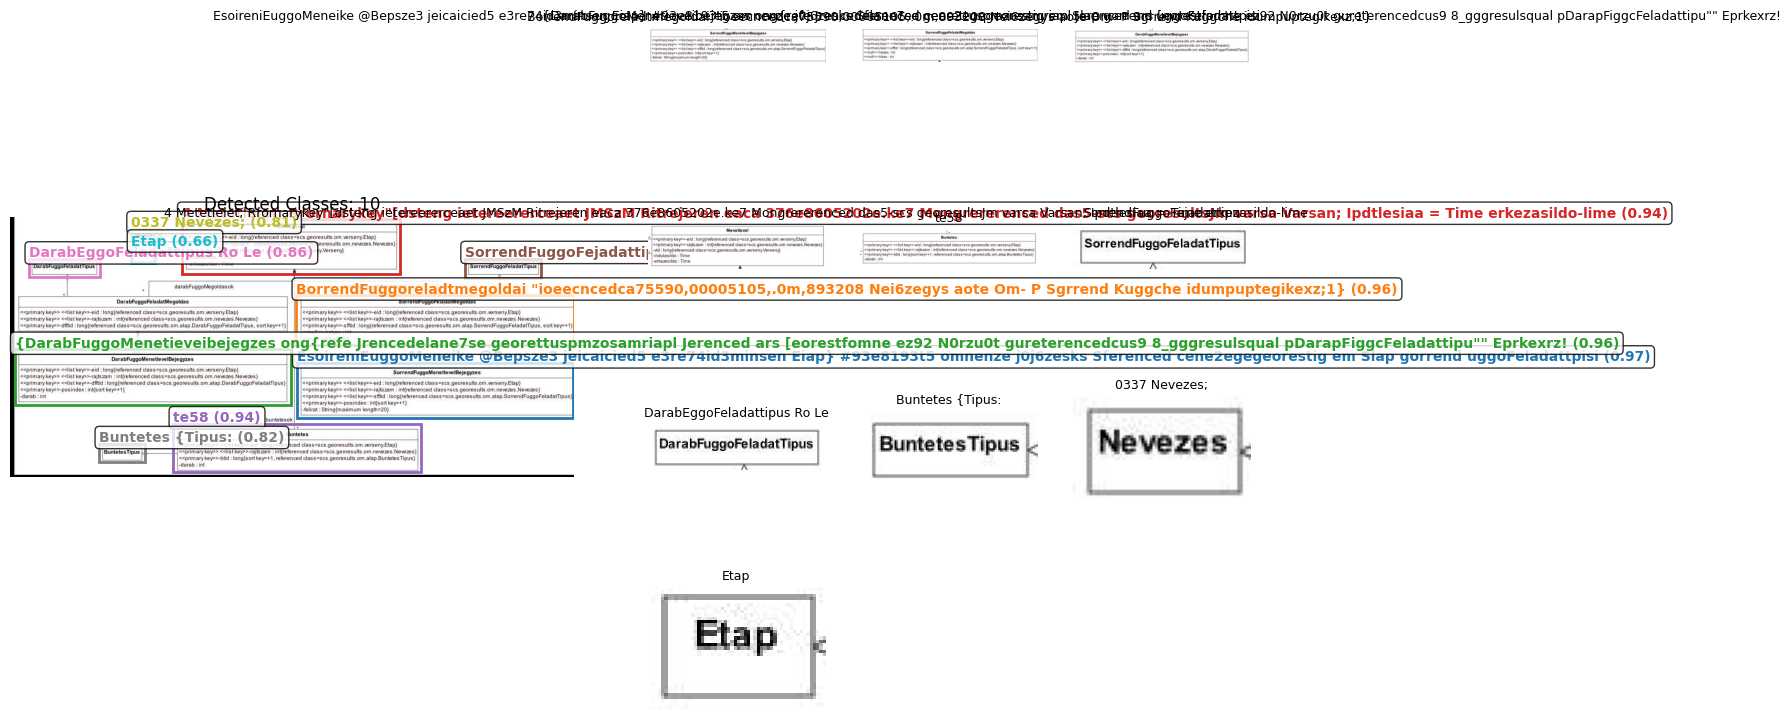

In [14]:
def visualize_extraction(image_path: str, result: Dict, figsize: Tuple[int, int] = (16, 10)):
    """
    Visualize the extraction results.
    
    Shows:
    - Original image with detected boxes
    - Cropped class boxes
    - Extracted text for each box
    """
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    num_classes = len(result['classes'])
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Main image with bounding boxes
    ax_main = fig.add_subplot(1, 2, 1)
    ax_main.imshow(image_rgb)
    ax_main.set_title(f"Detected Classes: {num_classes}")
    ax_main.axis('off')
    
    # Draw bounding boxes
    colors = plt.cm.tab10(np.linspace(0, 1, max(num_classes, 1)))
    for i, cls in enumerate(result['classes']):
        bbox = cls['bbox']
        rect = plt.Rectangle(
            (bbox['x1'], bbox['y1']),
            bbox['x2'] - bbox['x1'],
            bbox['y2'] - bbox['y1'],
            fill=False, color=colors[i], linewidth=2
        )
        ax_main.add_patch(rect)
        ax_main.text(
            bbox['x1'], bbox['y1'] - 5,
            f"{cls['class_name']} ({cls['detection_confidence']:.2f})",
            color=colors[i], fontsize=10, weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
    
    # Cropped regions and text
    if num_classes > 0:
        rows = (num_classes + 2) // 3  # 3 columns max
        for i, cls in enumerate(result['classes']):
            bbox = cls['bbox']
            cropped = image_rgb[bbox['y1']:bbox['y2'], bbox['x1']:bbox['x2']]
            
            ax = fig.add_subplot(rows, 6, (i // 3) * 6 + (i % 3) + 4)
            ax.imshow(cropped)
            ax.set_title(cls['class_name'] or 'Unknown', fontsize=9)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize the test result
visualize_extraction(test_image_path, result)

## 7. Batch Processing

In [15]:
def batch_extract(extractor: UMLTextExtractor, image_paths: List[Path], 
                  verbose: bool = True) -> List[Dict]:
    """
    Process multiple images and collect results.
    
    Args:
        extractor: UMLTextExtractor instance
        image_paths: List of image paths
        verbose: Print progress
    
    Returns:
        List of extraction results
    """
    results = []
    
    for i, path in enumerate(image_paths):
        if verbose:
            print(f"Processing {i+1}/{len(image_paths)}: {path.name}", end='\r')
        
        result = extractor.extract(path)
        results.append(result)
    
    if verbose:
        print(f"\nProcessed {len(results)} images")
    
    return results

In [16]:
# Process a batch of test images (limit for demo)
NUM_IMAGES = 10
batch_results = batch_extract(extractor, test_images[:NUM_IMAGES])

Processing 10/10: 184_jpeg.rf.3d59d91d260bd05639b8134ab47b5eac.jpg
Processed 10 images


In [17]:
# Calculate statistics
total_classes = sum(r['num_classes_detected'] for r in batch_results)
images_with_classes = sum(1 for r in batch_results if r['num_classes_detected'] > 0)

all_confidences = []
all_ocr_confidences = []
classes_with_names = 0
classes_with_attributes = 0
classes_with_methods = 0

for r in batch_results:
    for cls in r['classes']:
        all_confidences.append(cls['detection_confidence'])
        all_ocr_confidences.append(cls['ocr_confidence'])
        if cls['class_name']:
            classes_with_names += 1
        if cls['attributes']:
            classes_with_attributes += 1
        if cls['methods']:
            classes_with_methods += 1

print(f"Batch Processing Statistics")
print(f"{'='*40}")
print(f"Images processed: {len(batch_results)}")
print(f"Images with detections: {images_with_classes} ({images_with_classes/len(batch_results)*100:.1f}%)")
print(f"Total classes detected: {total_classes}")
print(f"Average classes per image: {total_classes/len(batch_results):.2f}")
print()
print(f"Detection confidence: {np.mean(all_confidences):.3f} +/- {np.std(all_confidences):.3f}")
print(f"OCR confidence: {np.mean(all_ocr_confidences):.3f} +/- {np.std(all_ocr_confidences):.3f}")
print()
print(f"Classes with extracted name: {classes_with_names} ({classes_with_names/max(total_classes,1)*100:.1f}%)")
print(f"Classes with attributes: {classes_with_attributes} ({classes_with_attributes/max(total_classes,1)*100:.1f}%)")
print(f"Classes with methods: {classes_with_methods} ({classes_with_methods/max(total_classes,1)*100:.1f}%)")

Batch Processing Statistics
Images processed: 10
Images with detections: 10 (100.0%)
Total classes detected: 109
Average classes per image: 10.90

Detection confidence: 0.903 +/- 0.040
OCR confidence: 0.500 +/- 0.000

Classes with extracted name: 109 (100.0%)
Classes with attributes: 19 (17.4%)
Classes with methods: 1 (0.9%)


## 8. Export Results

In [18]:
def export_results(results: List[Dict], output_path: Path):
    """
    Export extraction results to JSON file.
    
    Args:
        results: List of extraction results
        output_path: Path to save JSON file
    """
    # Convert Path objects to strings for JSON serialization
    serializable = []
    for r in results:
        r_copy = r.copy()
        r_copy['image_path'] = str(r_copy['image_path'])
        serializable.append(r_copy)
    
    with open(output_path, 'w') as f:
        json.dump(serializable, f, indent=2)
    
    print(f"Results exported to: {output_path}")


# Export batch results
output_file = OUTPUT_DIR / "ocr_extraction_results.json"
export_results(batch_results, output_file)

Results exported to: c:\Users\Aiden Smith\Desktop\CSC581-uml-query-tool\data\processed\ocr_results\ocr_extraction_results.json


In [19]:
# Verify exported data
with open(output_file, 'r') as f:
    loaded = json.load(f)

print(f"Loaded {len(loaded)} results from JSON")
print(f"\nFirst result preview:")
print(json.dumps(loaded[0], indent=2)[:1000] + "...")

Loaded 10 results from JSON

First result preview:
{
  "image_path": "C:\\Users\\Aiden Smith\\.cache\\kagglehub\\datasets\\domenicoarm\\uml-class-diagram-dataset-bounded-box-rating\\versions\\2\\UML_YOLOv8\\test\\images\\10_jpeg.rf.4507a97dfa42d52d8c46bbf80267fbc2.jpg",
  "image_size": {
    "width": 645,
    "height": 504
  },
  "num_classes_detected": 5,
  "classes": [
    {
      "bbox": {
        "x1": 0,
        "y1": 0,
        "x2": 320,
        "y2": 289
      },
      "detection_confidence": 0.9706993103027344,
      "class_name": "Rxlava Class > =",
      "attributes": [
        {
          "name": "@GenetlcAlgorithmsc;g",
          "type": "",
          "visibility": "public"
        }
      ],
      "methods": [
        {
          "name": "GeneticAlgortm",
          "parameters": [
            {
              "name": "Ropination<C  Ritess<cj22X {Glevolvel vold",
              "type": "evolvewntjzeid' getieratiojnin temm"
            }
          ],
          "return_type": 

## 9. Interactive Testing

Test the extractor on specific images to debug OCR issues.

Image: 10_jpeg.rf.4507a97dfa42d52d8c46bbf80267fbc2.jpg
Detected 5 class boxes



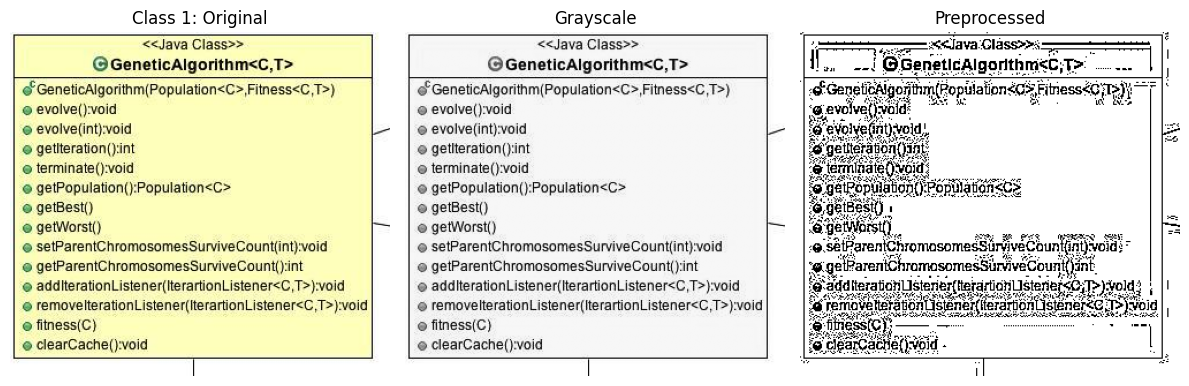


--- Class 1 OCR Results ---

Without preprocessing:
  <<Java Class>>
  GeneticAlgorithm<C,T>
  GeneticAlgorithm(Population<C > Fitness<C,T>) evolve()void evolve(int) void getlteration()int terminate()void getPopulation() Population<C > getBestt) getWorst() setParentChromosomesSurviveCountrint) void getParentChromosomesSurviveCount() int addlterationListener(lterartionListener<C T>)void removelterationListener(lterartionListener<C T>)void fitness(C) clearCache()void

With preprocessing:
  Rxlava Class > =
  @GenetlcAlgorithmsc;g:
  ~GeneticAlgortm(Ropination<C  Ritess<cj22X {Glevolvel vold: evolvewntjzeid' getieratiojnin temm)= 0xoid getpopmubon( Fopuamonscz detBest ~getivarste QeRaenchongsomessirivecouk ineevoia} addlteratio]lstererfmterartiot]lsterer C )vold: Temoveleratonustenerllerarionustener C[ ~oid hitessC cearcachertvoid_



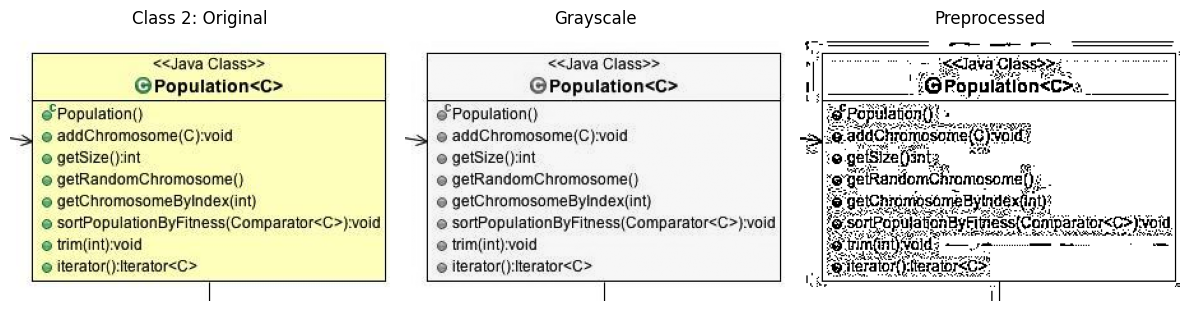


--- Class 2 OCR Results ---

Without preprocessing:
  <<Java Class>> GPopulation<C>
  Population() addChromosome(C)void getSize()int getRandomChromosome() getChromosomeBylndex(int) sortPopulationByFitness(Comparator<C?)void trim(int) void iterator() lterator<C >

With preprocessing:
  Qava iass ;3 @Popuiation Cz a e popmlationtk" daddcronosoine @yoia 'gelandomchromosome getChtomosomeBylndertnt)} sorifopulatoneyrque S(ConiparatorsC ) gid| Gdldi iterator



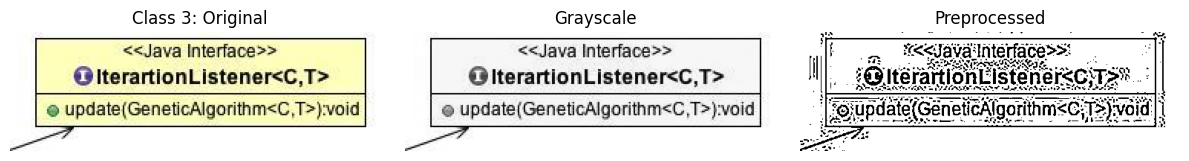


--- Class 3 OCR Results ---

Without preprocessing:
  << Java Interface >
  d IterartionListener<C,T> update(GeneticAlgorithm<C T>)void

With preprocessing:
  1cava liteitace > Ite) raitionListeneiscis" Riln = pdate(GeneticAlgorithm<C [2)voic



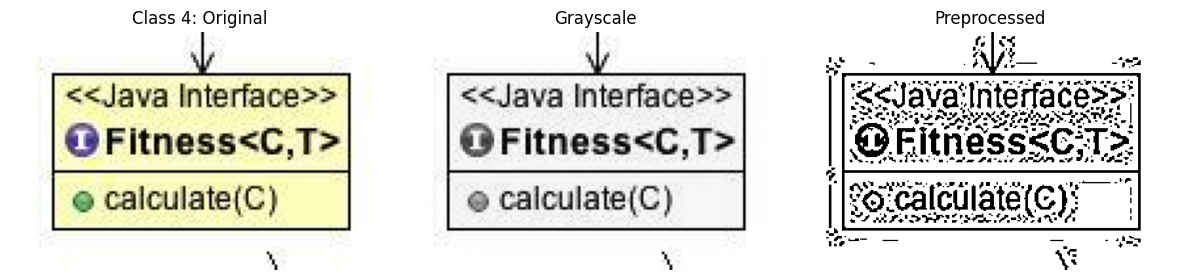


--- Class 4 OCR Results ---

Without preprocessing:
  <<Java Interface  > dFitness<C,T> calculate(C

With preprocessing:
  *clavailnteiiacez; TFitiesssC 4on o calculatelC)}



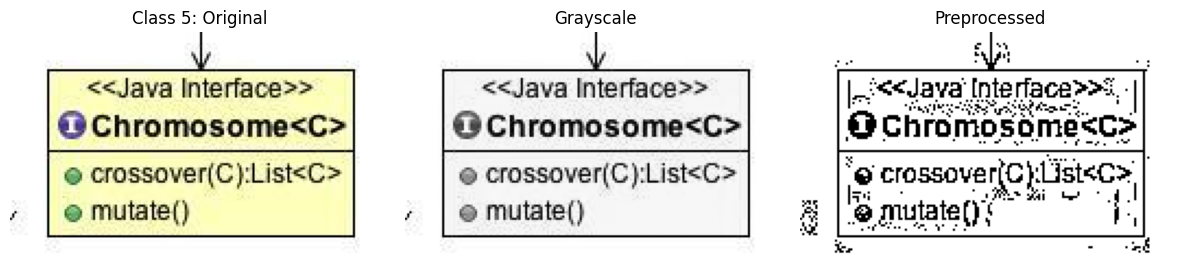


--- Class 5 OCR Results ---

Without preprocessing:
  <<Java Interace > Chromosome<C>
  crossover(C) List<C > mutate()

With preprocessing:
  {SrJav? {ptenacez 4 Chromosomezcz crossoveriC}LIstac; Mutatef)



In [20]:
def debug_ocr(image_path: Path, extractor: UMLTextExtractor):
    """
    Debug OCR extraction for a single image.
    Shows preprocessing steps and OCR output.
    """
    image = cv2.imread(str(image_path))
    detections = extractor.detect_classes(image)
    
    print(f"Image: {image_path.name}")
    print(f"Detected {len(detections)} class boxes\n")
    
    for i, det in enumerate(detections):
        bbox = det['bbox']
        cropped = crop_detection(image, bbox, padding=10)
        
        # Show original crop and preprocessed version
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        # Original crop
        axes[0].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Class {i+1}: Original")
        axes[0].axis('off')
        
        # Grayscale
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        axes[1].imshow(gray, cmap='gray')
        axes[1].set_title("Grayscale")
        axes[1].axis('off')
        
        # Preprocessed
        processed = preprocess_for_ocr(cropped)
        axes[2].imshow(processed, cmap='gray')
        axes[2].set_title("Preprocessed")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Run OCR on both versions
        print(f"\n--- Class {i+1} OCR Results ---")
        
        raw_results = extractor.ocr_reader.readtext(gray, paragraph=True)
        print(f"\nWithout preprocessing:")
        for r in raw_results:
            print(f"  {r[1] if len(r) > 1 else r[0]}")
        
        proc_results = extractor.ocr_reader.readtext(processed, paragraph=True)
        print(f"\nWith preprocessing:")
        for r in proc_results:
            print(f"  {r[1] if len(r) > 1 else r[0]}")
        
        print()


# Debug a specific image
debug_ocr(test_images[0], extractor)

## Summary

This notebook implements a complete OCR extraction pipeline for UML class diagrams:

1. **Detection**: Uses trained YOLOv8 model to detect class boxes
2. **Preprocessing**: Applies CLAHE, scaling, and adaptive thresholding
3. **OCR**: Extracts text using EasyOCR
4. **Parsing**: Structures text into class name, attributes, and methods
5. **Export**: Saves results as JSON for knowledge graph construction

### Next Steps
- **Notebook 04**: Build knowledge graph from extracted class relationships
- **Notebook 05**: Implement query interface with LLM